# CKA and CCA


### Code from "Similarity of Neural Network Representations Revisited"
```
@inproceedings{pmlr-v97-kornblith19a,
  title = {Similarity of Neural Network Representations Revisited},
  author = {Kornblith, Simon and Norouzi, Mohammad and Lee, Honglak and Hinton, Geoffrey},
  booktitle = {Proceedings of the 36th International Conference on Machine Learning},
  pages = {3519--3529},
  year = {2019},
  volume = {97},
  month = {09--15 Jun},
  publisher = {PMLR}
}
```


In [1]:
# get_ipython().config

In [2]:
#  get_ipython().config.TerminalInteractiveShell.cache_size = 0

In [3]:
# get_ipython().config

In [4]:
import time
from os import listdir
from os.path import join

import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import dill
from IPython.core.debugger import set_trace

import directory_structure as ds
import similarity_scores as ss

In [5]:
 pip install -U memory_profiler


Note: you may need to restart the kernel to use updated packages.


In [6]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%load_ext memory_profiler
%memit

peak memory: 344.64 MiB, increment: 0.14 MiB


In [7]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)



1 Physical GPUs, 1 Logical GPUs


In [8]:
test = np.zeros([1000, 2, 2, 4])
label = np.random.randint(2, size=1000)
print(label[label==1].shape)
testm = np.ma.masked_array(test)
testm[~np.isin(label, [1])] = np.ma.masked
test[np.isin(label, [1])].shape

(509,)


(509, 2, 2, 4)

In [119]:
class LayerOutputs():
    def __init__(self, outputs, custom_names, class_names, preds=None):
        self._outputs = outputs
        self._layer_samples = len(outputs[0])
        self._sample_mask = np.ones(self._layer_samples, dtype=bool)
        self._preds = preds
        self._indexer = np.arange(self.layer_samples)
        self.custom_names = custom_names
        self.class_names = class_names

        
    def average_dims(self, shape_threshold=2, axis=(1,2), inplace=False):
        new_tensors = []
        for l in self._outputs:
            if len(l.shape) > shape_threshold:
                new_tensors.append(np.mean(l, axis=axis))
            else:
                new_tensors.append(l)
        if inplace:
            self._outputs = new_tensors
        else:
            return new_tensors
    
    def get_tensors(self, dtype=tf.float32):
        lo = []
        for l in self.mask_outputs:
            lo.append(tf.Variable(l, dtype=dtype))
            
        return lo

    def add_sample_mask(self, mask):
        """ Combines mask with the existing self._sample_mask for the samples of self.outputs
        
            Args:
                mask (list, np.ndarray): A list or NumPy array of boolean values
                    whose size is equal to that of self._sample_mask.
        
        """
        new_mask = np.zeros(self._layer_samples, dtype=bool)
        unmask_indices = self.indexer[mask]
        new_mask[unmask_indices] = True
        self._sample_mask = np.bitwise_and(self._sample_mask, new_mask)
        
        
    def reset_masks(self, mask_name):
        """ Resets either class, sample, or both masks
        
            Args:
                mask_name (str): Name of the mask to reset. The value can
                    take on either 'sample', 'class', or 'both'.
        
        """
        if mask_name.lower() == 'sample':
            self._sample_mask = np.ones(self._layer_samples, dtype=bool)
#         elif mask_name.lower() == 'class':
#             self._class_mask = np.ones(self._layer_samples, dtype=bool)
#         elif mask_name.lower() == 'both':
#             self._sample_mask = np.ones(self._layer_samples, dtype=bool)
#             self._class_mask = np.ones(self._layer_samples, dtype=bool)
        else:
            err = "Invalid mask_name {}. The value must be must be 'sample', 'class' or 'both'"
            raise ValueError(err.format(mask_name))
  
    @property
    def outputs(self):
        return self._outputs
    
    @property
    def mask_outputs(self):
        if np.all(self._sample_mask):
            return self._outputs
        else:
            lo = []
            for l in  self._outputs:
                lo.append(l[self._sample_mask])
            return lo
        
    @property
    def layer_samples(self):
        return len(self._outputs[0][self._sample_mask])
    
    @property
    def preds(self):
       
        if np.all(self._sample_mask):
            return self._preds
        else:
            return self._preds.iloc[self._sample_mask]
        
    @property
    def indexer(self):
        return self._indexer[self._sample_mask]
        
class LayerOutputGroups():
    def __init__(self,):
        self._outputs_path_tmpl = join(ds.ROOT_DIR, ds.EXPS_DIR, '{}', 
                                            ds.TST_DIR, '{}')
        
    
    def __getitem__(self, index):
        """ Returns an array of LayerOutputs objects

            Args:
                index (list, tuple): A list or tuple of Pandas multi-index labels.
        
        """
        # Convert multi-index into proper format
        index = tuple([[str(i)] if not isinstance(i, (list, tuple)) else list(map(str, i)) for i in index])

        selected = self.data_map.loc[index]
        
        if hasattr(selected, 'ravel'):
            return selected.ravel()
        
        return selected
    
    def load_all_outputs(self, exp_names):
        exp_outputs = []
        tags = []
        tag_names = ['exp name', 'dataset', 'subject', 'trial']
        for exp_name in exp_names:
            
            # Build needed paths using template
            outputs_path = self._outputs_path_tmpl.format(exp_name, ds.LAYER_OUTPUTS_DIR)
            
            # Load file
            for lo_file in listdir(outputs_path):
                lo_path = join(outputs_path, lo_file)
                
                # Load dill file
                try:
                    with open(lo_path, 'rb') as f:
                        lo = LayerOutputs(*dill.load(f))
                except Exception as e:
                    print("Failed to load {} due to '{}'".format(lo_file, e))
                    continue
                    
                # Append tag layer output file
                t = (exp_name, *lo_file.split('-'))
                tags.append(t)
                
                # Append layer outputs
                exp_outputs.append(lo)
        
        # Build multi-index Pandas Series  
        multi_idx = pd.MultiIndex.from_tuples(tags, names=tag_names)
        self.data_map = pd.Series(exp_outputs, index=multi_idx).sort_index()
        
    def load_all_layer_info(self, exp_names, preds_ext='csv'):
        exp_outputs = []
        tags = []
        tag_names = ['exp name', 'dataset', 'subject', 'trial']
        for exp_name in exp_names:
            # Build needed paths using template
            outputs_path = self._outputs_path_tmpl.format(exp_name, ds.LAYER_OUTPUTS_DIR)
            layer_preds_path = self._outputs_path_tmpl.format(exp_name, ds.PREDS_DIR)

            # Load files
            for lo_file in listdir(outputs_path):       
                lo_path = join(outputs_path, lo_file)
                preds_path = join(layer_preds_path, lo_file + '.' + preds_ext)
                
                # Load dill file
                try:
                    with open(lo_path, 'rb') as f:
                        lo_params = dill.load(f)
                except Exception as e:
                    print("Failed to load {} due to '{}'".format(lo_file, e))
                    continue
                    
                # Build LayerOutputs Object
                preds = pd.read_csv(preds_path)
                lo = LayerOutputs(*lo_params, preds=preds)
                    
                # Append tag layer output file
                t = (exp_name, *lo_file.split('-'))
                tags.append(t)
                
                # Append layer outputs
                exp_outputs.append(lo)
        
        # Build multi-index Pandas Series  
        multi_idx = pd.MultiIndex.from_tuples(tags, names=tag_names)
        self.data_map = pd.Series(exp_outputs, index=multi_idx).sort_index()

    def apply_method(self, method_name, index=None, **kwargs):
        """ Applies any LayerOutput method to all or certain indices 
        
            
        """
        if index is None:
            selected = self.data_map.values
        else:
            selected = self[index]
            if len(selected) == 0:
                err = "The following index {} was not found in the data_map"
                raise IndexError(err.format(index))
            
        for lo in selected:
            bound_method = getattr(lo, method_name)
            bound_method(**kwargs)

In [120]:
def equalize_samples(grps, index=None, random=False):
    """ Equalizies the sample dimension for indices in a LayerOutputGroups object

            Makes sure all inputs for each layer are the same as all other
            LayerOutputs. If they are not then all LayerOutputs are reduced to 
            the smallest input size by either randomly droping samples or cutting off
            the samples on the end.

            Note:
                Buffer of 1-2 seconds is usually added to the end of DBCI data making
                no random dropping potentially better.
                
            Args:
                grps (LayerOutputGroups): 
                
                index (list, tuple): A list of lists or a list of strings that are formatted 
                    to index a multi-index pandas.Series. For more information
                    on the format see the following pandas multi-index documentation:
                    https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html.
                    All indexes utilize the pandas.IndexSlice wrapper, i.e. format according
                    to the pandas.IndexSlice format.
                
                random (bool): If true samples are reduced randomly without replacement.
    
    """
    if index is None:
        selected = grps.data_map.values
    else:
        selected = grps[index]
        if len(selected) == 0:
            err = "The following index {} was not found in the data_map"
            raise IndexError(err.format(index))
        if selected.size == 1:
            return grps

    # Find min samples for all selected LayerOutputs instances
    samples = [s.layer_samples for s in selected]
    # If all the min samples are equal then return
    if np.all(samples == samples[0]):
        return grps
    min_samples = min(samples)

    for lo in selected:
        assert len(lo.indexer) >= min_samples
        
        if random:
            indices = np.random.choice(lo.indexer, size=(min_samples,), replace=False)
        else:
            indices = np.arange(min_samples)
            
        sample_mask = np.isin(lo.indexer, indices)
        lo.add_sample_mask(sample_mask)
    
    return grps

def select_classes(grps, class_labels, index=None, use_pred_column=False):
    """ Creates a mask for for self._outputs based on classes

        By default the mask is based the label column of LayerOutputs.preds.
        However, by one can use the prediction column by setting the parameter
        use_pred_column to True.
        
        WARNING: If a mask already exists it will be utilized! 

        Args:
            grps (LayerOutputGroups):
            
            class_labels (list, tuple): Specifies which classes leave unmasked
            
            index (list, tuple): A list of lists or a list of strings that are formatted 
                    to index a multi-index pandas.Series. For more information
                    on the format see the following pandas multi-index documentation:
                    https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html.
                    All indexes utilize the pandas.IndexSlice wrapper, i.e. format according
                    to the pandas.IndexSlice format.

            use_pred_column (bool): If True then the prediction column for self.preds
                will be used instead of the default label column.

    """
    if index is None:
        selected = grps.data_map.values
    else:
        selected = grps[index]
        if len(selected) == 0:
            err = "The following index {} was not found in the data_map"
            raise IndexError(err.format(index))


    if use_pred_column:
        column = 'prediction'
    else:
        column = 'label'

    for lo in selected:
        masked_preds = lo.preds.loc[:, column].values
        class_mask = np.isin(masked_preds, class_labels)
        lo.add_sample_mask(class_mask)
        
    return grps

In [121]:
import gc
print(gc.collect())
exp_names = ['oaout-1-9', 'oaobs-1-9']
grps = LayerOutputGroups()
grps.load_all_layer_info(exp_names)
print(grps.data_map)

95
exp name   dataset  subject  trial
oaobs-1-9  OAObs    1        10       <__main__.LayerOutputs object at 0x7f9d8b3b3950>
           OAOut    1        1        <__main__.LayerOutputs object at 0x7f9d8b3b09d0>
                             10       <__main__.LayerOutputs object at 0x7f9d8b3aba50>
                             2        <__main__.LayerOutputs object at 0x7f9d8b3c08d0>
                             3        <__main__.LayerOutputs object at 0x7f9d8b3bb990>
                             4        <__main__.LayerOutputs object at 0x7f9d8b3ab990>
                             5        <__main__.LayerOutputs object at 0x7f9d8b3bb8d0>
                             6        <__main__.LayerOutputs object at 0x7f9d8b3bf890>
                             7        <__main__.LayerOutputs object at 0x7f9d8b3b0910>
                             8        <__main__.LayerOutputs object at 0x7f9d8b3b3a10>
                             9        <__main__.LayerOutputs object at 0x7f9d8b3a8b90>
oaout

If you display `grps.data_map` and then rerun the same cell again the memory will double! Not sure why this occurs but seems to be linked to pandas table display and jupyter notebooks caching of outputs/display. HOWEVER, using `print` seems fine...

**If memory grows too big simply restart the notebook's kernel!**

In [142]:
%memit

peak memory: 8617.64 MiB, increment: 0.06 MiB


In [126]:
select = (['oaobs-1-9', 'oaout-1-9'], ['OAObs', 'OAOut'], ['1'], ['10'])
obs2obs = grps['oaobs-1-9', 'OAObs', '1', '10'][0]
obs2out = grps['oaobs-1-9', 'OAOut', '1', '10'][0]
out2out = grps['oaout-1-9', 'OAOut', '1', '10'][0]
out2obs = grps['oaout-1-9', 'OAObs', '1', '10'][0]
out2obs9 = grps['oaout-1-9', 'OAObs', '1', '9'][0]

In [127]:
select_classes(grps, index=select, class_labels=[1]);

In [128]:
obs2obs.preds

,class 0,class 1,prediction,label
21,0.439405,0.560594,1.0,1.0
73,0.101813,0.898187,1.0,1.0
135,0.286809,0.713191,1.0,1.0
271,0.396753,0.603247,1.0,1.0
503,0.271923,0.728077,1.0,1.0
583,0.573905,0.426095,0.0,1.0
686,0.757127,0.242873,0.0,1.0
987,0.107345,0.892655,1.0,1.0
1047,0.034130,0.965870,1.0,1.0
1093,0.642636,0.357364,0.0,1.0


In [129]:
for l in out2obs.mask_outputs:
    print(l.shape)

(13, 8, 4, 128)
(13, 8, 4, 128)
(13, 16, 1, 128)
(13, 16, 1, 128)
(13, 16, 1, 128)
(13, 16, 1, 32)
(13, 16, 1, 32)
(13, 16, 1, 32)
(13, 16, 1, 32)
(13, 16, 1, 32)
(13, 16, 1, 4)
(13, 16, 1, 4)
(13, 64)
(13, 2)
(13, 2)


In [130]:
equalize_samples(grps=grps, index=select, random=True);

In [131]:
obs2obs.preds

,class 0,class 1,prediction,label
21,0.439405,0.560594,1.0,1.0
271,0.396753,0.603247,1.0,1.0
503,0.271923,0.728077,1.0,1.0
686,0.757127,0.242873,0.0,1.0
1093,0.642636,0.357364,0.0,1.0
1145,0.424155,0.575845,1.0,1.0
1690,0.092776,0.907224,1.0,1.0
1724,0.270760,0.729240,1.0,1.0


In [132]:
for l in obs2obs.mask_outputs:
    print(l.shape)

(8, 8, 4, 128)
(8, 8, 4, 128)
(8, 16, 1, 128)
(8, 16, 1, 128)
(8, 16, 1, 128)
(8, 16, 1, 32)
(8, 16, 1, 32)
(8, 16, 1, 32)
(8, 16, 1, 32)
(8, 16, 1, 32)
(8, 16, 1, 4)
(8, 16, 1, 4)
(8, 64)
(8, 2)
(8, 2)


In [133]:
for l in obs2out.mask_outputs:
    print(l.shape)

(8, 8, 4, 128)
(8, 8, 4, 128)
(8, 16, 1, 128)
(8, 16, 1, 128)
(8, 16, 1, 128)
(8, 16, 1, 32)
(8, 16, 1, 32)
(8, 16, 1, 32)
(8, 16, 1, 32)
(8, 16, 1, 32)
(8, 16, 1, 4)
(8, 16, 1, 4)
(8, 64)
(8, 2)
(8, 2)


In [134]:
obs2obs.average_dims(inplace=True)
obs2out.average_dims(inplace=True)
out2out.average_dims(inplace=True)
out2obs.average_dims(inplace=True)
out2obs9.average_dims(inplace=True)

In [135]:
for l in obs2obs.mask_outputs:
    print(l.shape)

(8, 128)
(8, 128)
(8, 128)
(8, 128)
(8, 128)
(8, 32)
(8, 32)
(8, 32)
(8, 32)
(8, 32)
(8, 4)
(8, 4)
(8, 64)
(8, 2)
(8, 2)


In [136]:
for l in obs2out.mask_outputs:
    print(l.shape)

(8, 128)
(8, 128)
(8, 128)
(8, 128)
(8, 128)
(8, 32)
(8, 32)
(8, 32)
(8, 32)
(8, 32)
(8, 4)
(8, 4)
(8, 64)
(8, 2)
(8, 2)


In [137]:
obs2obs.class_names

['Conv2D',
 'BatchNormalization',
 'DepthwiseConv2D',
 'BatchNormalization',
 'Activation',
 'AveragePooling2D',
 'Dropout',
 'SeparableConv2D',
 'BatchNormalization',
 'Activation',
 'AveragePooling2D',
 'Dropout',
 'Flatten',
 'Dense',
 'Activation']

(<Figure size 1440x1440 with 2 Axes>, <AxesSubplot:title={'center':'CKA'}>)

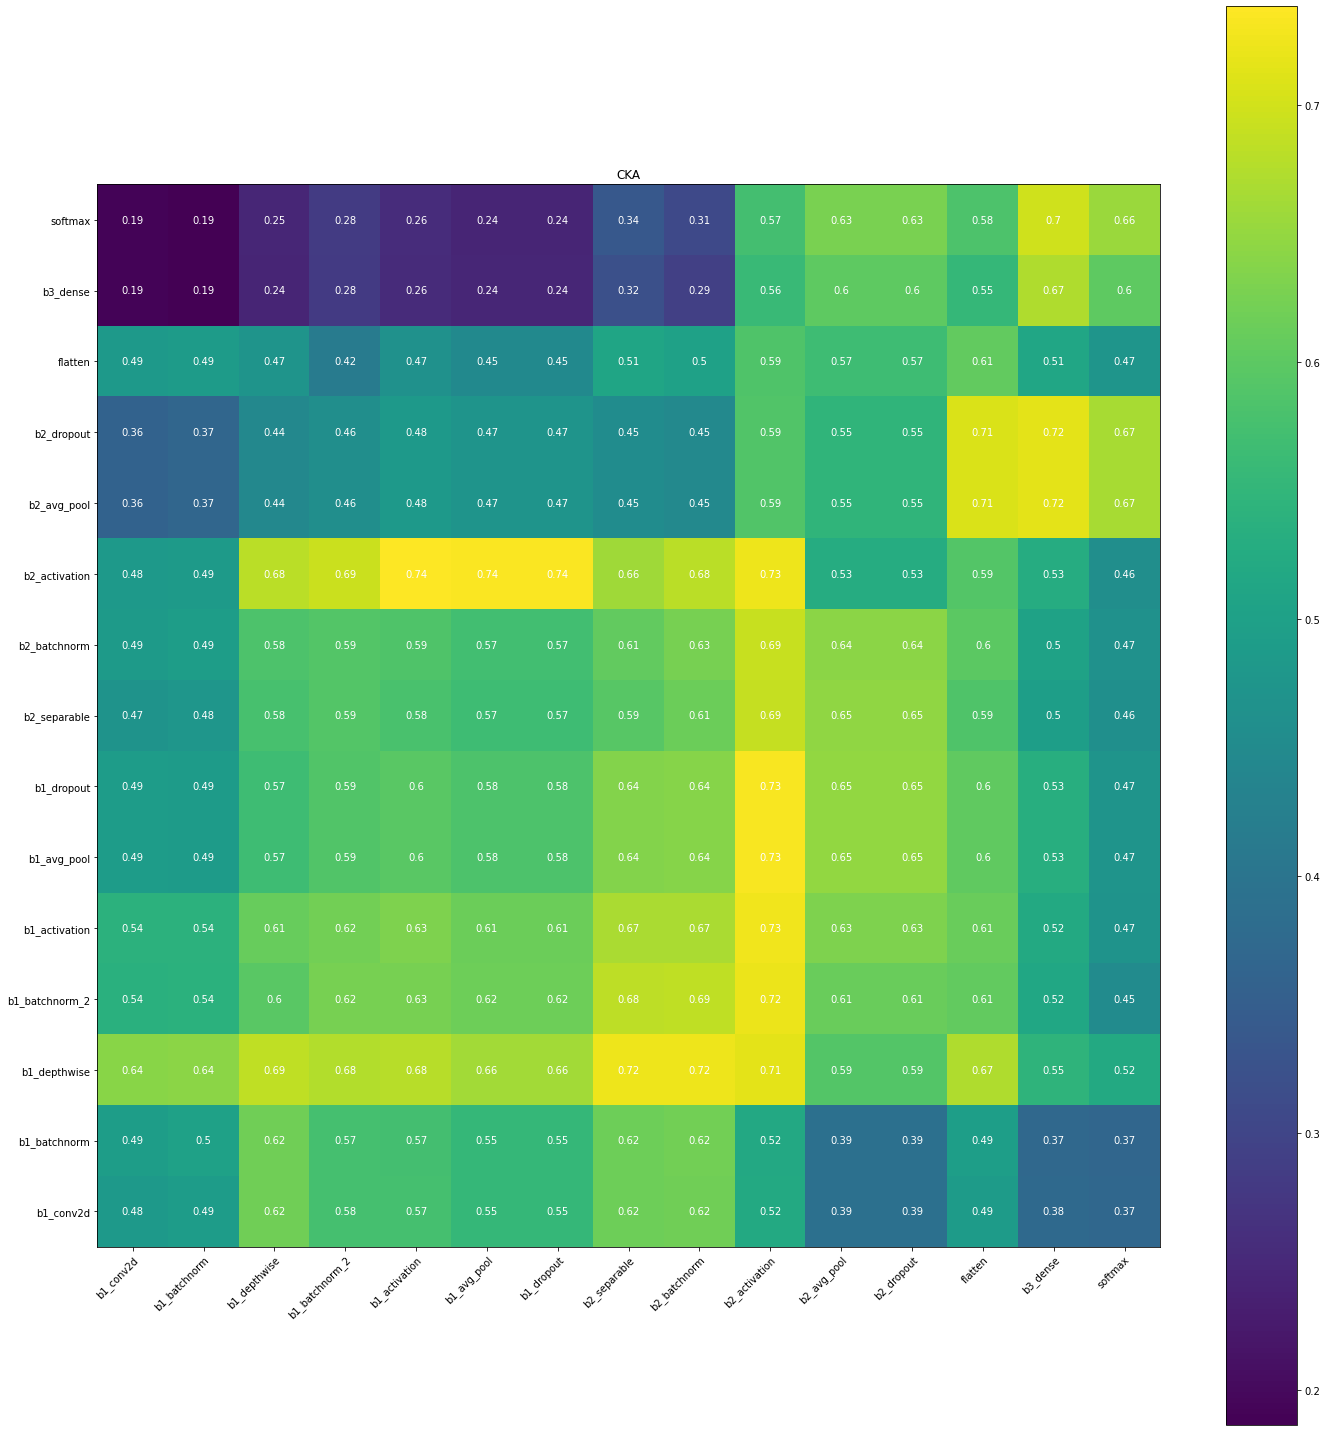

In [138]:
layer_scores = ss.cka_compare_all_layers(obs2obs.get_tensors(), obs2out.get_tensors())
ss.get_network_similarity_plot(layer_scores, obs2obs.custom_names, obs2out.custom_names)

(<Figure size 1440x1440 with 2 Axes>, <AxesSubplot:title={'center':'CKA'}>)

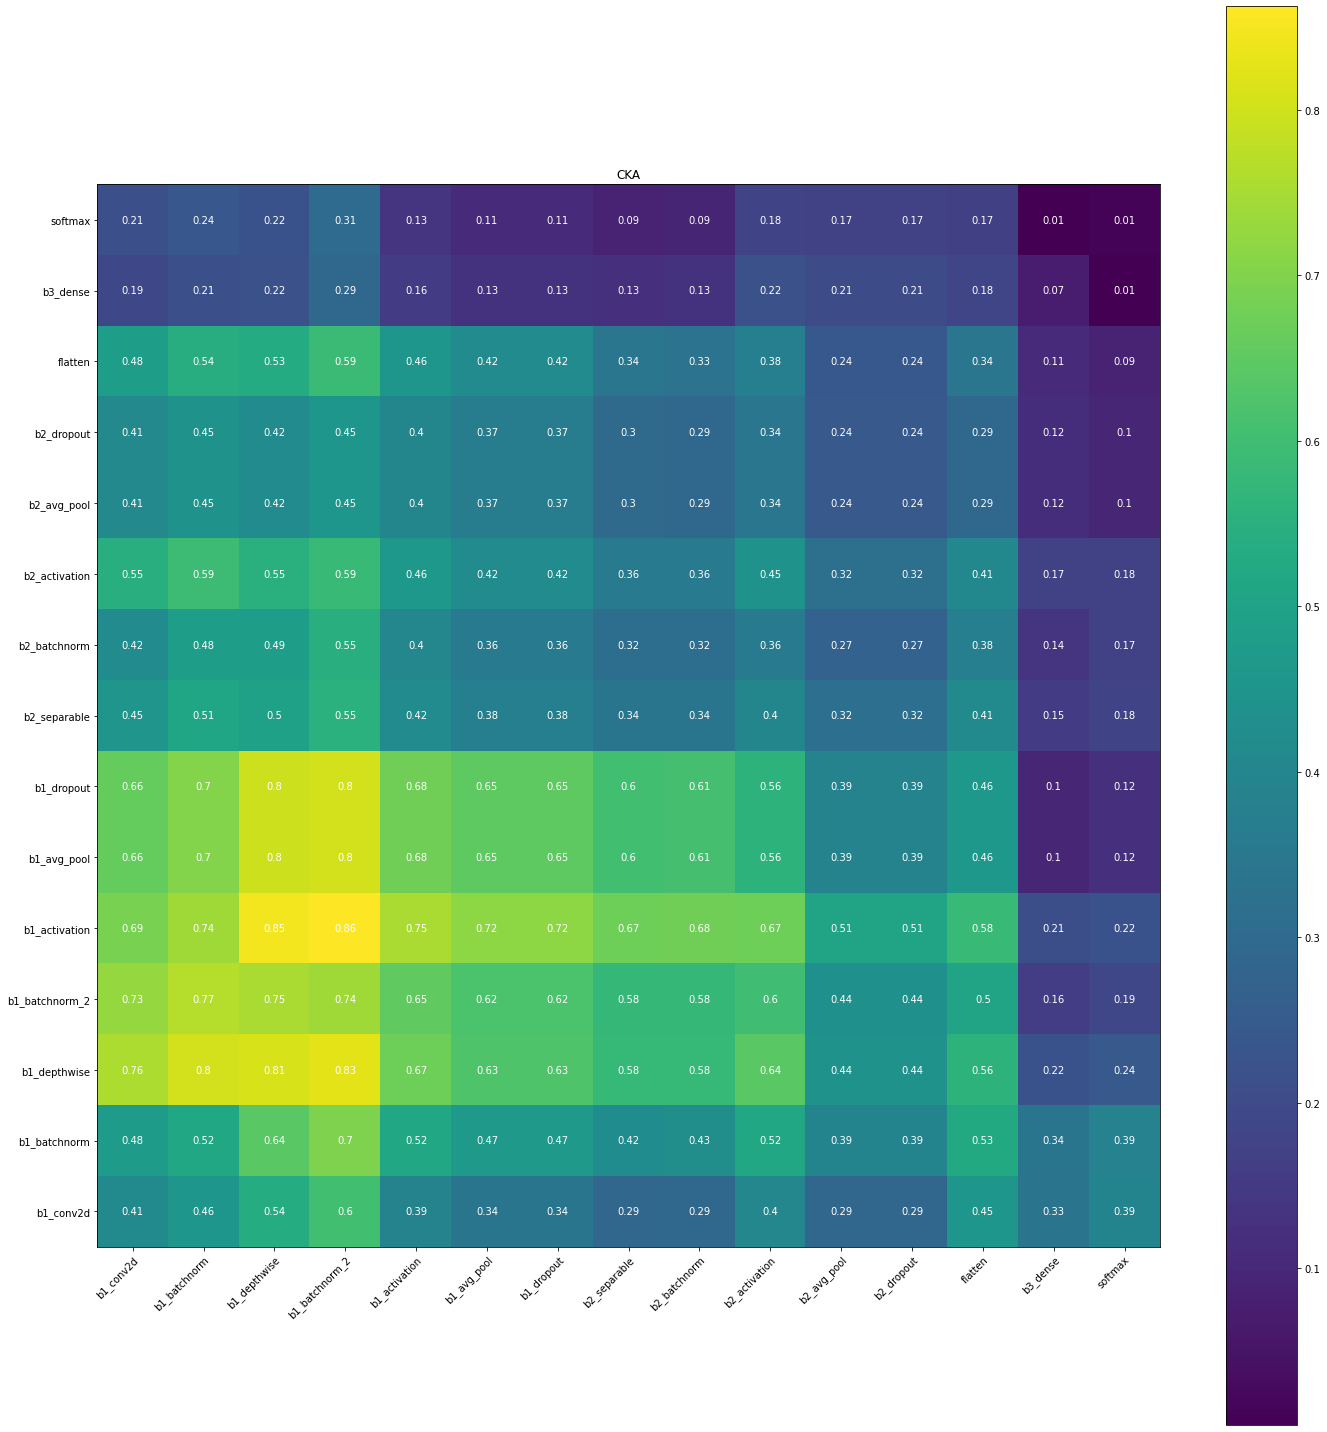

In [141]:
layer_scores = ss.cka_compare_all_layers(out2out.get_tensors(), out2obs.get_tensors())
ss.get_network_similarity_plot(layer_scores, out2obs.custom_names, out2obs9.custom_names)